In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from json import dump, load
from os.path import exists
from sklearn.metrics import rand_score, f1_score, recall_score, confusion_matrix, precision_score
import itertools
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [13]:
#read in data
train_df = pd.read_csv('Genre Classification Dataset-IMDB/train_data.txt', sep=' ::: ', names=['Title', 'Genre', 'Description'], engine='python')
test_df = pd.read_csv('Genre Classification Dataset-IMDB/test_data.txt', sep=' ::: ', names=['Title', 'Description'], engine='python')
test_df_solution = pd.read_csv('Genre Classification Dataset-IMDB/test_data_solution.txt', sep=' ::: ', names=['Title', 'Genre', 'Description'], engine='python')

# Data Exploration

In [14]:
pd.set_option('display.max_colwidth', None)
print(len(train_df))
train_df.head()

54214


,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue."
2,Cupid (1997),thriller,A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
3,"Young, Wild and Wonderful (1980)",adult,"As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. After the films, they release the emotion of the fantasies in the most erotic and uncommon ways. One slips off to the curator's office for a little ""acquisition. "" Another finds the anthropologist to see what bones can be identified. Even the head teacher isn't immune. Soon the tour is over, but as the bus departs, everyone admits it was quite an education."
4,The Secret Sin (1915),drama,"To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstresses . An invalid, Grace falls prey to the temptations of Chinatown opium and becomes an addict, a condition worsened by a misguided physician who prescribes morphine to ease her pain. When their father strikes oil, the family enjoys a new prosperity and the sisters meet the eligible Jack Herron, a fellow oil prospector. To Grace's shock, Jack falls in love with Edith and in her jealousy, Grace tells Jack that Edith, not she, has a drug problem. Hinting that her sister will soon need more morphine, Grace arranges for a dinner in Chinatown with the couple. While her sister and Jack dance, Grace slips away to an opium den. Edith follows her, but ends up in the wrong den and is arrested in an ensuing drug raid. After he bails her out of jail, Edith takes an angry Jack to search for Grace and stumbles across her half-conscious body lying in the street. The truth about the sisters is revealed, and after sending Grace to a sanitarium in the country, Jack and Edith are married."
5,The Unrecovered (2007),drama,"The film's title refers not only to the un-recovered bodies at ground zero, but also to the state of the nation at large. Set in the hallucinatory period of time between September 11 and Halloween of 2001, The Unrecovered examines the effect of terror on the average mind, the way a state of heightened anxiety and/or alertness can cause the average person to make the sort of imaginative connections that are normally made only by artists and conspiracy theorists-both of whom figure prominently in this film. The Unrecovered explores the way in which irony, empathy, and paranoia relate to one another in the wake of 9/11."


<Axes: xlabel='Genre'>

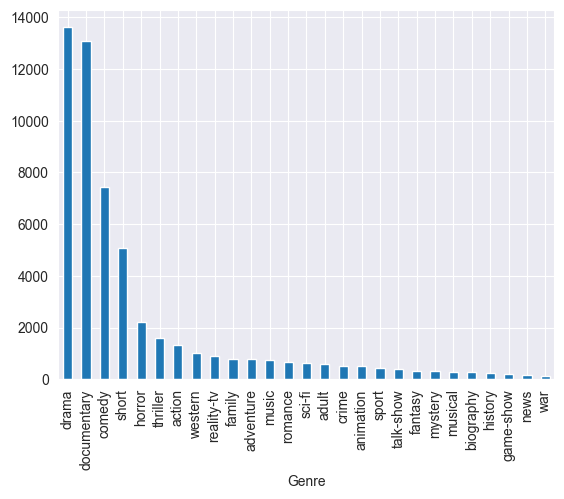

In [15]:
#data distribution
train_df['Genre'].value_counts().plot(kind='bar')

In [16]:
#check for null values
train_df.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [17]:
test_df.isnull().sum()

Title          0
Description    0
dtype: int64

# Preprocessing

In [18]:
# the index of train_df begins at 1, we change it to start at 0
train_df.index = train_df.index - 1

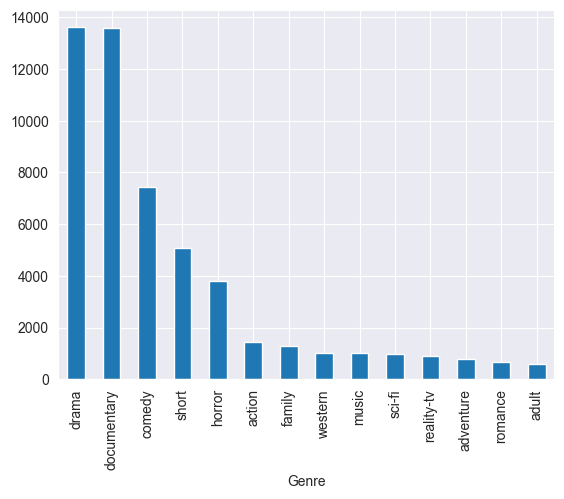

In [19]:
#create a new dataset the new tags
train_df_new_categories = train_df.copy()
#if the genre is biography or history change it to documentary
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['biography', 'history'], 'documentary')
#if the genre is thriller change it to horror
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['thriller'], 'horror')
#if the genre is  war change it to action
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['war'], 'action')
#if the genre is animation change it to family
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['animation'], 'family')
#if the genre is musical change it to music
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['musical'], 'music')
#if the genre is fantasy change it to sci-fi
train_df_new_categories['Genre'] = train_df_new_categories['Genre'].replace(['fantasy'], 'sci-fi')
#remove the genres that represent less than 1% of the data
train_df_new_categories = train_df_new_categories.groupby('Genre').filter(lambda x : len(x)>(len(train_df)/100))
#print the remaining genres
train_df_new_categories['Genre'].value_counts().plot(kind='bar')
#reset the index
train_df_new_categories = train_df_new_categories.reset_index()

still very unbalanced

In [20]:
# create n balanced datasets
n_datasets = 10
balanced_datasets = []
labels = []
for i in range(n_datasets):
    new_batch = train_df.groupby('Genre').apply(lambda x: x.sample(1000,replace = True)).reset_index(drop=True)
    balanced_datasets.append(new_batch)
    labels.append(new_batch['Genre'])

In [21]:
n_datasets_new_categories = 10
balanced_datasets_new_categories = []
labels_new_categories = []
for i in range(n_datasets):
    new_batch = train_df_new_categories.groupby('Genre').apply(lambda x: x.sample(1000,replace = True)).reset_index(drop=True)
    balanced_datasets_new_categories.append(new_batch)
    labels_new_categories.append(new_batch['Genre'])

# models
## vectorize data

In [22]:
# vectorize each dataset with unigram
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
vectorizer.fit(train_df['Description'])
vectorizer_initial_df = vectorizer.transform(train_df['Description'])
vectorizer_balanced_df = []
for i in range(n_datasets):
    vectorizer_balanced_df.append(vectorizer.transform(balanced_datasets[i]['Description']))
vectorizer_new_categories_df = vectorizer.transform(train_df_new_categories['Description'])
vectorizer_balanced_new_categories_df = []
for i in range(n_datasets_new_categories):
    vectorizer_balanced_new_categories_df.append(vectorizer.transform(balanced_datasets_new_categories[i]['Description']))

## models definition

In [23]:
def fit_kmeans(data, max_iter=300  ,n_clusters=8, n_init=10, kmeans=None):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.
        kmeans: A k-means classifier to use. If None, a new classifier will be created.

    Returns:
        The trained k-means classifier.
    """
    if kmeans is None:
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter)
    kmeans.fit(data)
    return kmeans

In [24]:
def fit_random_forest(data, labels, n_estimators=100, max_depth=None, rf=None):
    """Fit a random forest classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        labels: The gold-standard labels.
        n_estimators (int): The number of trees in the forest.
        rf: A random forest classifier to use. If None, a new classifier will be created.

    Returns:
        The trained random forest classifier.
    """
    if rf is None:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    rf.fit(data, labels)
    return rf

In [14]:
def fit_knn(data, labels, n_neighbors=5, weights='uniform', knn=None):
    """Fit a k-nearest neighbors classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        labels: The gold-standard labels.
        n_neighbors (int): The number of neighbors to consider.
        knn: A k-nearest neighbors classifier to use. If None, a new classifier will be created.

    Returns:
        The trained k-nearest neighbors classifier.
    """
    if knn is None:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    knn.fit(data, labels)
    return knn

## choose the best parameters for each model

In [ ]:
if exists('best_params.json'):
    best_params = load(open('best_params.json'))
else:
    best_params = {}

In [ ]:
# kmeans
if 'kmeans' not in best_params:
    best_params['kmeans'] = {}
    
kmeans = KMeans()
grid = {'n_clusters': [3, 5, 10], 'n_init': [1, 5, 10], 'max_iter': [100, 200, 300]}

#initial df
if 'initial df' not in best_params['kmeans']:
    kmeans_grid_init = GridSearchCV(kmeans, grid, cv=5, scoring='rand_score', verbose=2)
    kmeans_grid_init.fit(vectorizer_initial_df)
    print(kmeans_grid_init.cv_results_)
    best_params['kmeans']['initial df'] = kmeans_grid_init.best_params_
    dump(best_params, open('best_params.json', 'w'))

#balanced df
if 'balanced df' not in best_params['kmeans']:
    temp_df = sparse.vstack(vectorizer_balanced_df)
    kmeans_grid_balanced = GridSearchCV(kmeans, grid, cv=5, scoring='rand_score', verbose=2)
    kmeans_grid_balanced.fit(temp_df)
    print(kmeans_grid_balanced.cv_results_)
    best_params['kmeans']['balanced df'] = kmeans_grid_balanced.best_params_
    dump(best_params, open('best_params.json', 'w'))

#new categories df
if 'new categories df' not in best_params['kmeans']:
    kmeans_grid_new_categories = GridSearchCV(kmeans, grid, cv=5, scoring='rand_score', verbose=2)
    kmeans_grid_new_categories.fit(vectorizer_new_categories_df)
    print(kmeans_grid_new_categories.cv_results_)
    best_params['kmeans']['new categories df'] = kmeans_grid_new_categories.best_params_
    dump(best_params, open('best_params.json', 'w'))
    
#balanced new categories df
if 'balanced new categories df' not in best_params['kmeans']:
    temp_df = sparse.vstack(vectorizer_balanced_new_categories_df)
    kmeans_grid_balanced_new_categories = GridSearchCV(kmeans, grid, cv=5, scoring='rand_score', verbose=2)
    kmeans_grid_balanced_new_categories.fit(temp_df)
    print(kmeans_grid_balanced_new_categories.cv_results_)
    best_params['kmeans']['balanced new categories df'] = kmeans_grid_balanced_new_categories.best_params_
    dump(best_params, open('best_params.json', 'w'))

In [ ]:
# random forest
if 'random forest' not in best_params:
    best_params['random forest'] = {}

rf = RandomForestClassifier()
grid = {'n_estimators': [100, 200], 'max_depth': [None, 20]}

#initial df
if 'initial df' not in best_params['random forest']:
    rf_grid_init = GridSearchCV(rf, grid, cv=3, scoring='rand_score', verbose=2)
    rf_grid_init.fit(vectorizer_initial_df, train_df['Genre'])
    print(rf_grid_init.cv_results_)
    best_params['random forest']['initial df'] = rf_grid_init.best_params_
    dump(best_params, open('best_params.json', 'w'))
    
#balanced df
if 'balanced df' not in best_params['random forest']:
    temp_df = sparse.vstack(vectorizer_balanced_df)
    labels_temp = list(itertools.chain.from_iterable(labels))
    rf_grid_balanced = GridSearchCV(rf, grid, cv=3, scoring='rand_score', verbose=2)
    rf_grid_balanced.fit(temp_df, labels_temp)
    print(rf_grid_balanced.cv_results_)
    best_params['random forest']['balanced df'] = rf_grid_balanced.best_params_
    dump(best_params, open('best_params.json', 'w'))
    
#new categories df
if 'new categories df' not in best_params['random forest']:
    rf_grid_new_categories = GridSearchCV(rf, grid, cv=3, scoring='rand_score', verbose=2)
    rf_grid_new_categories.fit(vectorizer_new_categories_df, train_df_new_categories['Genre'])
    print(rf_grid_new_categories.cv_results_)
    best_params['random forest']['new categories df'] = rf_grid_new_categories.best_params_
    dump(best_params, open('best_params.json', 'w'))
     
#balanced new categories df
if 'balanced new categories df' not in best_params['random forest']:
    temp_df = sparse.vstack(vectorizer_balanced_new_categories_df)
    labels_temp = list(itertools.chain.from_iterable(labels_new_categories))
    rf_grid_balanced_new_categories = GridSearchCV(rf, grid, cv=3, scoring='rand_score', verbose=2)
    rf_grid_balanced_new_categories.fit(temp_df, labels_temp)
    print(rf_grid_balanced_new_categories.cv_results_)
    best_params['random forest']['balanced new categories df'] = rf_grid_balanced_new_categories.best_params_
    dump(best_params, open('best_params.json', 'w'))

In [ ]:
#knn
if 'knn' not in best_params:
    best_params['knn'] = {}

knn = KNeighborsClassifier()
grid = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}

#initial df
if 'initial df' not in best_params['knn']:
    knn_grid_init = GridSearchCV(knn, grid, cv=3, scoring='rand_score', verbose=2)
    knn_grid_init.fit(vectorizer_initial_df, train_df['Genre'])
    print(knn_grid_init.cv_results_)
    best_params['knn']['initial df'] = knn_grid_init.best_params_
    dump(best_params, open('best_params.json', 'w'))
    
#balanced df
# if 'balanced df' not in best_params['knn']: #this takes too long
#     temp_df = sparse.vstack(vectorizer_balanced_df)
#     labels_temp = list(itertools.chain.from_iterable(labels))
#     knn_grid_balanced = GridSearchCV(knn, grid, cv=3, scoring='rand_score', verbose=2)
#     knn_grid_balanced.fit(temp_df, labels_temp)
#     print(knn_grid_balanced.cv_results_)
#     best_params['knn']['balanced df'] = knn_grid_balanced.best_params_
#     dump(best_params, open('best_params.json', 'w'))
    
#new categories df
if 'new categories df' not in best_params['knn']:
    knn_grid_new_categories = GridSearchCV(knn, grid, cv=3, scoring='rand_score', verbose=2)
    knn_grid_new_categories.fit(vectorizer_new_categories_df, train_df_new_categories['Genre'])
    print(knn_grid_new_categories.cv_results_)
    best_params['knn']['new categories df'] = knn_grid_new_categories.best_params_
    dump(best_params, open('best_params.json', 'w'))
    
#balanced new categories df
# if 'balanced new categories df' not in best_params['knn']: #this takes too long
#     temp_df = sparse.vstack(vectorizer_balanced_new_categories_df)
#     labels_temp = list(itertools.chain.from_iterable(labels_new_categories))
#     knn_grid_balanced_new_categories = GridSearchCV(knn, grid, cv=3, scoring='rand_score', verbose=2)
#     knn_grid_balanced_new_categories.fit(temp_df, labels_temp)
#     print(knn_grid_balanced_new_categories.cv_results_)
#     best_params['knn']['balanced new categories df'] = knn_grid_balanced_new_categories.best_params_
#     dump(best_params, open('best_params.json', 'w'))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


## models selection
we use cross validation to select the best model

In [22]:
#load json file with cross validation results
if exists('cross_validation_results.json') :
    cross_validation_results = load(open('cross_validation_results.json'))
else:
    cross_validation_results = {}

In [26]:
if exists('best_params.json'):
    best_params = load(open('best_params.json'))
    # add default parameters for the grid search that took too long
    if 'kmeans' not in best_params:
         best_params['kmeans'] = {'initial df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'balanced df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'new categories df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'balanced new categories df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}}
    if 'random forest' not in best_params:
        best_params['random forest'] = {'initial df': {'n_estimators': 100, 'max_depth': None},
                                    'balanced df': {'n_estimators': 100, 'max_depth': None},
                                    'new categories df': {'n_estimators': 100, 'max_depth': None},
                                    'balanced new categories df': {'n_estimators': 100, 'max_depth': None}}
    if 'knn' not in best_params:
        best_params['knn'] = {'initial df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'balanced df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'new categories df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'balanced new categories df': {'n_neighbors': 3, 'weights': 'uniform'}}
    if 'initial df' not in best_params['kmeans']:
        best_params['kmeans']['initial df'] = {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}
    if 'balanced df' not in best_params['kmeans']:
        best_params['kmeans']['balanced df'] = {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}
    if 'new categories df' not in best_params['kmeans']:
        best_params['kmeans']['new categories df'] = {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}
    if 'balanced new categories df' not in best_params['kmeans']:
        best_params['kmeans']['balanced new categories df'] = {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}
    if 'initial df' not in best_params['random forest']:
        best_params['random forest']['initial df'] = {'n_estimators': 100, 'max_depth': None}
    if 'balanced df' not in best_params['random forest']:
        best_params['random forest']['balanced df'] = {'n_estimators': 100, 'max_depth': None}
    if 'new categories df' not in best_params['random forest']:
        best_params['random forest']['new categories df'] = {'n_estimators': 100, 'max_depth': None}
    if 'balanced new categories df' not in best_params['random forest']:
        best_params['random forest']['balanced new categories df'] = {'n_estimators': 100, 'max_depth': None}
    if 'initial df' not in best_params['knn']:
        best_params['knn']['initial df'] = {'n_neighbors': 3, 'weights': 'uniform'}
    if 'balanced df' not in best_params['knn']:
        best_params['knn']['balanced df'] = {'n_neighbors': 3, 'weights': 'uniform'}
    if 'new categories df' not in best_params['knn']:
        best_params['knn']['new categories df'] = {'n_neighbors': 3, 'weights': 'uniform'}
    if 'balanced new categories df' not in best_params['knn']:
        best_params['knn']['balanced new categories df'] = {'n_neighbors': 3, 'weights': 'uniform'}
else:
    best_params = {}
    # add default parameters
    best_params['kmeans'] = {'initial df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'balanced df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'new categories df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100},
                             'balanced new categories df': {'n_clusters': 3, 'n_init': 1, 'max_iter': 100}}
    best_params['random forest'] = {'initial df': {'n_estimators': 100, 'max_depth': None},
                                    'balanced df': {'n_estimators': 100, 'max_depth': None},
                                    'new categories df': {'n_estimators': 100, 'max_depth': None},
                                    'balanced new categories df': {'n_estimators': 100, 'max_depth': None}}
    best_params['knn'] = {'initial df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'balanced df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'new categories df': {'n_neighbors': 3, 'weights': 'uniform'},
                            'balanced new categories df': {'n_neighbors': 3, 'weights': 'uniform'}}

In [17]:
# create kfold object
kf = KFold(n_splits=10, shuffle=True)

In [ ]:
#cross validation on the initial dataset
scores_kmeans = []
rand_scores_rf = []
F1_scores_rf = []
rand_scores_knn = []
F1_scores_knn = []

if 'initial df' not in cross_validation_results:
    cross_validation_results['initial df'] = {}
    
for train_index, test_index in kf.split(vectorizer_initial_df):
    
    #split data
    X_train, X_test = vectorizer_initial_df[train_index], vectorizer_initial_df[test_index]
    y_train, y_test = train_df['Genre'][train_index], train_df['Genre'][test_index]
    
    #fit and evaluate the models
    if 'rand_kmeans' not in cross_validation_results['initial df']:
        kmeans = fit_kmeans(X_train, **best_params['kmeans']['initial df'])
        scores_kmeans.append(rand_score(y_test, kmeans.predict(X_test)))
    
    if 'rand_rf' not in cross_validation_results['initial df']:
        rf = fit_random_forest(X_train, y_train, **best_params['random forest']['initial df'])
        rand_scores_rf.append(rand_score(y_test, rf.predict(X_test)))
        F1_scores_rf.append(f1_score(y_test, rf.predict(X_test), average='weighted'))
    
    # if 'rand_knn' not in cross_validation_results['initial df']:#this takes too long
    #     knn = fit_knn(X_train, y_train, **best_params['knn']['initial df'])
    #     rand_scores_knn.append(rand_score(y_test, knn.predict(X_test)))
    #     F1_scores_knn.append(f1_score(y_test, knn.predict(X_test), average='weighted'))

if scores_kmeans!=[]: cross_validation_results['initial df']['rand_kmeans'] = scores_kmeans
if rand_scores_rf!=[]: cross_validation_results['initial df']['rand_rf'] = rand_scores_rf
if F1_scores_rf!=[]: cross_validation_results['initial df']['F1_rf'] = F1_scores_rf
if rand_scores_knn!=[]: cross_validation_results['initial df']['rand_knn'] = rand_scores_knn
if F1_scores_knn!=[]: cross_validation_results['initial df']['F1_knn'] = F1_scores_knn
dump(cross_validation_results, open('cross_validation_results.json', 'w'))

In [ ]:
#cross validation on the balanced datasets
scores_kmeans_balanced = []
rand_scores_rf_balanced = []
F1_scores_rf_balanced = []
rand_scores_knn_balanced = []
F1_scores_knn_balanced = []

if 'balanced df' not in cross_validation_results:
    cross_validation_results['balanced df'] = {}
        
for i in range(n_datasets):
    # the ith dataset is used as test set and the rest as training set
    X_test = vectorizer_balanced_df[i]
    X_train = sparse.vstack(vectorizer_balanced_df[:i] + vectorizer_balanced_df[i+1:])
    y_test = balanced_datasets[i]['Genre']
    y_train = labels[:i] + labels[i+1:]
    y_train = list(itertools.chain.from_iterable(y_train))
    
    #fit and evaluate the models
    if 'rand_kmeans' not in cross_validation_results['balanced df']:
        kmeans = fit_kmeans(X_train, **best_params['kmeans']['balanced df'])
        scores_kmeans_balanced.append(rand_score(y_test, kmeans.predict(X_test)))
        
    if 'rand_rf' not in cross_validation_results['balanced df']:
        rf = fit_random_forest(X_train, y_train, **best_params['random forest']['balanced df'])
        rand_scores_rf_balanced.append(rand_score(y_test, rf.predict(X_test)))
        F1_scores_rf_balanced.append(f1_score(y_test, rf.predict(X_test), average='weighted'))
    
    # if 'rand_knn' not in cross_validation_results['balanced df']: #this takes too long
    #     knn = fit_knn(X_train, y_train, **best_params['knn']['balanced df'])
    #     rand_scores_knn_balanced.append(rand_score(y_test, knn.predict(X_test)))
    #     F1_scores_knn_balanced.append(f1_score(y_test, knn.predict(X_test), average='weighted'))
    
        
if scores_kmeans_balanced!=[]: cross_validation_results['balanced df']['rand_kmeans'] = scores_kmeans_balanced
if rand_scores_rf_balanced!=[]:cross_validation_results['balanced df']['rand_rf'] = rand_scores_rf_balanced
if F1_scores_rf_balanced!=[]:cross_validation_results['balanced df']['F1_rf'] = F1_scores_rf_balanced
if rand_scores_knn_balanced!=[]:cross_validation_results['balanced df']['rand_knn'] = rand_scores_knn_balanced
if F1_scores_knn_balanced!=[]:cross_validation_results['balanced df']['F1_knn'] = F1_scores_knn_balanced    
dump(cross_validation_results, open('cross_validation_results.json', 'w'))

In [ ]:
#cross validation on the dataset with new categories
scores_kmeans_new_categories = []
rand_scores_rf_new_categories = []
F1_scores_rf_new_categories = []
rand_scores_knn_new_categories = []
F1_scores_knn_new_categories = []

if 'new categories df' not in cross_validation_results:
    cross_validation_results['new categories df'] = {}
        
for train_index, test_index in kf.split(vectorizer_new_categories_df):
    #split data
    X_train, X_test = vectorizer_new_categories_df[train_index], vectorizer_new_categories_df[test_index]
    y_train, y_test = train_df_new_categories['Genre'][train_index], train_df_new_categories['Genre'][test_index]
    
    #fit and evaluate the models
    if 'rand_kmeans' not in cross_validation_results['new categories df']:
        kmeans = fit_kmeans(X_train, **best_params['kmeans']['new categories df'])
        scores_kmeans_new_categories.append(rand_score(y_test, kmeans.predict(X_test)))
        
    if 'rand_rf' not in cross_validation_results['new categories df']:
        rf = fit_random_forest(X_train, y_train, **best_params['random forest']['new categories df'])
        rand_scores_rf_new_categories.append(rand_score(y_test, rf.predict(X_test)))
        F1_scores_rf_new_categories.append(f1_score(y_test, rf.predict(X_test), average='weighted'))
    
    if 'rand_knn' not in cross_validation_results['new categories df']:
        knn = fit_knn(X_train, y_train, **best_params['knn']['new categories df'])
        rand_scores_knn_new_categories.append(rand_score(y_test, knn.predict(X_test)))
        F1_scores_knn_new_categories.append(f1_score(y_test, knn.predict(X_test), average='weighted'))

if scores_kmeans_new_categories!=[]: cross_validation_results['new categories df']['rand_kmeans'] = scores_kmeans_new_categories
if rand_scores_rf_new_categories!=[]:cross_validation_results['new categories df']['rand_rf'] = rand_scores_rf_new_categories
if F1_scores_rf_new_categories!=[]:cross_validation_results['new categories df']['F1_rf'] = F1_scores_rf_new_categories
if rand_scores_knn_new_categories!=[]:cross_validation_results['new categories df']['rand_knn'] = rand_scores_knn_new_categories
if F1_scores_knn_new_categories!=[]:cross_validation_results['new categories df']['F1_knn'] = F1_scores_knn_new_categories
dump(cross_validation_results, open('cross_validation_results.json', 'w'))

In [ ]:
#cross validation on the balanced datasets with new categories
scores_kmeans_balanced_new_categories = []
rand_scores_rf_balanced_new_categories = []
F1_scores_rf_balanced_new_categories = []
rand_scores_knn_balanced_new_categories = []
F1_scores_knn_balanced_new_categories = []

if 'balanced new categories df' not in cross_validation_results:
    cross_validation_results['balanced new categories df'] = {}
        
for i in range(n_datasets_new_categories):
    # the ith dataset is used as test set and the rest as training set
    X_test = vectorizer_balanced_new_categories_df[i]
    X_train = sparse.vstack(vectorizer_balanced_new_categories_df[:i] + vectorizer_balanced_new_categories_df[i+1:])
    y_test = balanced_datasets_new_categories[i]['Genre']
    y_train = labels_new_categories[:i] + labels_new_categories[i+1:]
    y_train = list(itertools.chain.from_iterable(y_train))
    
    #fit and evaluate the models
    if 'rand_kmeans' not in cross_validation_results['balanced new categories df']:
        kmeans = fit_kmeans(X_train)
        scores_kmeans_balanced_new_categories.append(rand_score(y_test, kmeans.predict(X_test)))
        
    if 'rand_rf' not in cross_validation_results['balanced new categories df']:
        rf = fit_random_forest(X_train, y_train)
        rand_scores_rf_balanced_new_categories.append(rand_score(y_test, rf.predict(X_test)))
        F1_scores_rf_balanced_new_categories.append(f1_score(y_test, rf.predict(X_test), average='weighted'))
    
    # if 'rand_knn' not in cross_validation_results['balanced new categories df']:#this takes too long
    #     knn = fit_knn(X_train, y_train)
    #     rand_scores_knn_balanced_new_categories.append(rand_score(y_test, knn.predict(X_test)))
    #     F1_scores_knn_balanced_new_categories.append(f1_score(y_test, knn.predict(X_test), average='weighted'))
        
if scores_kmeans_balanced_new_categories!=[]: cross_validation_results['balanced new categories df']['rand_kmeans'] = scores_kmeans_balanced_new_categories
if rand_scores_rf_balanced_new_categories!=[]:cross_validation_results['balanced new categories df']['rand_rf'] = rand_scores_rf_balanced_new_categories
if F1_scores_rf_balanced_new_categories!=[]:cross_validation_results['balanced new categories df']['F1_rf'] = F1_scores_rf_balanced_new_categories
if rand_scores_knn_balanced_new_categories!=[]:cross_validation_results['balanced new categories df']['rand_knn'] = rand_scores_knn_balanced_new_categories
if F1_scores_knn_balanced_new_categories!=[]:cross_validation_results['balanced new categories df']['F1_knn'] = F1_scores_knn_balanced_new_categories
dump(cross_validation_results, open('cross_validation_results.json', 'w'))

In [66]:
# print the results of the cross validation as a table
cross_validation_results = load(open('cross_validation_results.json'))

print('initial df')
print('kmeans')
print('rand score ', (np.mean(cross_validation_results['initial df']['rand_kmeans'])))
print('rf')
print('rand score ', np.mean(cross_validation_results['initial df']['rand_rf']))
print('F1 score ', np.mean(cross_validation_results['initial df']['F1_rf']))
print('knn')
print('rand score ', np.mean(cross_validation_results['initial df']['rand_knn']))
print('F1 score ', np.mean(cross_validation_results['initial df']['F1_knn']))
print('####################################################')

print('balanced df')
print('kmeans')
print('rand score ', np.mean(cross_validation_results['balanced df']['rand_kmeans']))
print('rf')
print('rand score ', np.mean(cross_validation_results['balanced df']['rand_rf']))
print('F1 score ', np.mean(cross_validation_results['balanced df']['F1_rf']))
# print('knn') #this takes too long
# print(np.mean(cross_validation_results['balanced df']['rand_knn']))
# print(np.mean(cross_validation_results['balanced df']['F1_knn']))
print('####################################################')

print('new categories df')
print('kmeans')
print('rand score ', np.mean(cross_validation_results['new categories df']['rand_kmeans']))
print('rf')
print('rand score ', np.mean(cross_validation_results['new categories df']['rand_rf']))
print('F1 score ', np.mean(cross_validation_results['new categories df']['F1_rf']))
print('knn')
print('rand score ', np.mean(cross_validation_results['new categories df']['rand_knn']))
print('F1 score ', np.mean(cross_validation_results['new categories df']['F1_knn']))
print('####################################################')

print('balanced new categories df')
print('kmeans')
print('rand score ', np.mean(cross_validation_results['balanced new categories df']['rand_kmeans']))
print('rf')
print('rand score ', np.mean(cross_validation_results['balanced new categories df']['rand_rf']))
print('F1 score ', np.mean(cross_validation_results['balanced new categories df']['F1_rf']))
# print('knn') #this takes too long
# print(np.mean(cross_validation_results['balanced new categories df']['rand_knn']))
# print(np.mean(cross_validation_results['balanced new categories df']['F1_knn']))


initial df
kmeans
rand score  0.5832324186235421
rf
rand score  0.6425313673785811
F1 score  0.39453479524660784
knn
rand score  0.752739668094798
F1 score  0.3371013788723464
####################################################
balanced df
kmeans
rand score  0.5147409083738356
rf
rand score  0.9972090678255572
F1 score  0.979366847688848
####################################################
new categories df
kmeans
rand score  0.583068933301401
rf
rand score  0.6505429268270854
F1 score  0.43384372174649455
knn
rand score  0.7299460987466042
F1 score  0.3669002975687328
####################################################
balanced new categories df
kmeans
rand score  0.8197847458491931
rf
rand score  0.9940998459073608
F1 score  0.0


The best model is the random forest on the dataset with new categories

In [97]:
precision_score(rf.predict(X_test), y_test, average='weighted', zero_division=0)

0.0

In [92]:
recall_score(rf.predict(X_test), y_test, average='weighted', zero_division=0)

0.0

# Test

In [30]:
predictions = pd.read_csv('test_data_prediction.txt', sep=',', names=['Title', 'Genre', 'Description'])['Genre']

In [37]:
#fit the best models on the dataset that gave the best results
rf_best = fit_random_forest(vectorizer_new_categories_df, train_df_new_categories['Genre'], **best_params['random forest']['new categories df'])

In [38]:
#predict the genres of the test set
predictions = rf_best.predict(vectorizer.transform(test_df['Description']))

In [40]:
#evaluate the predictions
print("rand score " ,rand_score(test_df_solution['Genre'], predictions))
print("F1 score ", f1_score(test_df_solution['Genre'], predictions, average='weighted'))
print("precision score ", precision_score(test_df_solution['Genre'], predictions, average='weighted', zero_division=0))
print("recall score ", recall_score(test_df_solution['Genre'], predictions, average='weighted', zero_division=0))

rand score  0.646264092099029
F1 score  0.3961301609060697
precision score  0.5016345562444307
recall score  0.48981549815498154


In [41]:
#confusion matrix
confusion_matrix(test_df_solution['Genre'], predictions)

array([[   14,     0,     0,     0,     0,    45,     0,   328,   876,
            0,     0,     0,     0,    41,     1,     0,     0,     0,
            0,     0,     4,     4,     0,     0,     0,     0,     1],
       [    0,    42,    16,     0,     0,    71,     0,   109,   343,
            0,     0,     0,     0,     4,     0,     0,     0,     0,
            0,     0,     0,     5,     0,     0,     0,     0,     0],
       [    1,    27,    75,     0,     0,    40,     0,   219,   392,
            0,     0,     0,     0,    13,     0,     0,     0,     0,
            0,     0,     1,     5,     0,     0,     0,     0,     2],
       [    0,     0,     0,     0,     0,    66,     0,   163,   246,
            4,     0,     0,     0,     8,     0,     0,     0,     0,
            0,     0,     2,     9,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     5,     0,   191,    66,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
  

Text(0.5, 1.0, 'Confusion matrix')

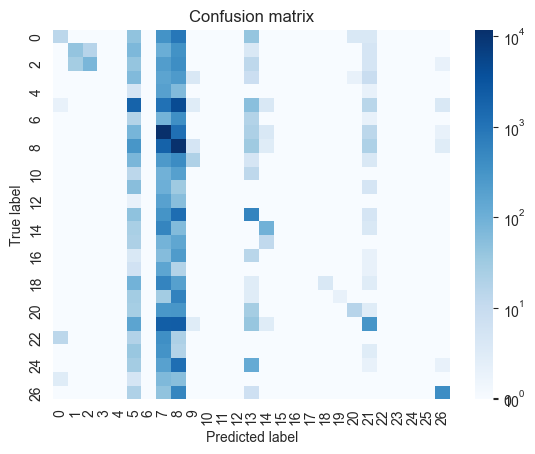

In [47]:
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(test_df_solution['Genre'], predictions),  fmt='g', cmap='Blues',norm=SymLogNorm(linthresh=1, linscale=0.01))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')